In [4]:
!pip install git+https://github.com/DLR-RM/stable-baselines3

  Cloning https://github.com/DLR-RM/stable-baselines3 to c:\users\ideco\appdata\local\temp\pip-req-build-89i6hh9a
  Resolved https://github.com/DLR-RM/stable-baselines3 to commit 002850f8ace0e045f7e9d370149a6fbb6cbcebad
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/DLR-RM/stable-baselines3 'C:\Users\ideco\AppData\Local\Temp\pip-req-build-89i6hh9a'


In [6]:
!pip install highway_env

In [7]:
!pip install ipywidgets
!pip install moviepy
!pip install gym pyvirtualdisplay

In [15]:
!pip install gym

In [1]:
import gym
import highway_env
import numpy as np

from stable_baselines3 import DDPG, HerReplayBuffer, SAC
from stable_baselines3.common.noise import NormalActionNoise
from sb3_contrib import TQC

In [2]:
env = gym.make("parking-v0")

설치 후 커널 재시작 필요. 재시작 하지 않으면 gym.make에서 오류가 발생합니다.

In [3]:
n_actions = env.action_space.shape[0]
noise_std = 0.2
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=noise_std * np.ones(n_actions))
goal_selection_strategy = "future"


model = DDPG('MultiInputPolicy', env, learning_rate=1e-3, buffer_size=int(1e6), batch_size=256, gamma=0.95,
        action_noise=action_noise, replay_buffer_class=HerReplayBuffer,  replay_buffer_kwargs=dict(
        n_sampled_goal=4,
        goal_selection_strategy=goal_selection_strategy,
        online_sampling=True,
        max_episode_length=100), policy_kwargs=dict(net_arch=[256, 256, 256]), verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [4]:
model.learn(int(1500))

model.save('ddpg_parking_1500')

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | -554     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 58       |
|    time_elapsed    | 7        |
|    total_timesteps | 456      |
| train/             |          |
|    actor_loss      | 3.42     |
|    critic_loss     | 2.58e+03 |
|    learning_rate   | 0.001    |
|    n_updates       | 179      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 68.4     |
|    ep_rew_mean     | -531     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 41       |
|    time_elapsed    | 13       |
|    total_timesteps | 547      |
| train/             |          |
|    actor_loss      | 2.43     |
|    critic_loss     | 734      |
|    learning_

In [5]:
model = DDPG.load('ddpg_parking_1500', env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


5000


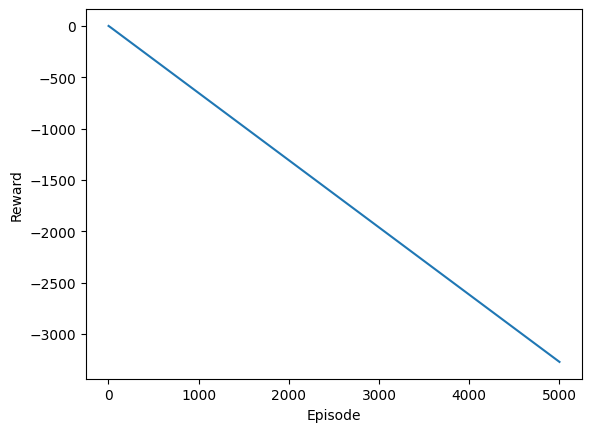

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

obs = env.reset()

# Evaluate
episode_reward = 0
rewards = []
for n in range(5000):
    if len(obs) ==2:
        action, _ = model.predict(obs[0], deterministic=True)
    elif len(obs) ==3:
        action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    episode_reward += reward

    rewards.append(episode_reward)
    if done or info.get('is_success', False):
        print('\rEpisode {}\tReward: {:.2f}'.format(n, episode_reward, end=""), "\tSuccess?", info.get('is_success', False))
        episode_reward = 0.0
        obs = env.reset()

print(len(rewards))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

In [7]:
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import RecordVideo
from pathlib import Path
import base64
from tqdm.notebook import trange

def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))



In [ ]:
env = gym.make("parking-v0")
env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda e: True)
env.unwrapped.set_record_video_wrapper(env)
for episode in trange(10, desc="Test episodes"):
    obs, done = env.reset(), False
    while not done:
        if len(obs) ==2:
            action, _ = model.predict(obs[0])
        elif len(obs) ==3:
            action, _ = model.predict(obs)
        obs, reward, done, _, info = env.step(action)
env.close()
show_video('./video')



시뮬레이션 시각화 코드